# Φόρτωση Βιβλιοθηκών

In [57]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras_tuner

from tensorflow import keras
from keras import backend as K
from keras.layers import Layer
from keras.initializers import Initializer
from keras.datasets import boston_housing
from keras.utils import np_utils
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
from timeit import default_timer as timer
from tensorflow.keras.optimizers import RMSprop

# 1. Απλή Εφαρμογή σε RBF δίκτυο

Αρχικά δημιουργούμε την κλάση του RBF στρώματος.

In [48]:
class RBF(Layer):
    #initialize the layer class
    def __init__(self,output_dimension,initializer=None, betas=1.0, **kwargs):
        self.output_dimension = output_dimension
        self.betas = betas
        if not initializer:
            self.initializer = RandomUniform(0.0,1.0)
        else: 
            self.initializer = initializer
        
        super(RBF, self).__init__(**kwargs) # calls the base or super layer’s init function
    
    #implement Radial Basis Function
    def build(self, input_shape):
        self.centers = self.add_weight(name='centers',
                               shape=(self.output_dimension, input_shape[1]),
                               initializer=self.initializer,
                               trainable=False)
        
        d_max = 0
        for i in range(0, self.output_dimension):
            for j in range(0, self.output_dimension):
                d = np.linalg.norm(self.centers[i] - self.centers[j])
                if d > d_max:
                    d_max = d
        sigma = d_max / np.sqrt(2 * self.output_dimension)
        self.betas = np.ones(self.output_dimension) / (2 * (sigma ** 2))
        super(RBF, self).build(input_shape)

    #calculate the dot product between the weights and the input. The input is passed as a parameter and the result of the dot product is returned.
    def call(self,x):
        C = K.expand_dims(self.centers, -1)
        H = K.transpose(C-K.transpose(x))
        return K.exp(-self.betas * K.sum(H**2, axis=1))

Και δημιουργούμε μια κλάση για την υλοποίηση του K-Means

In [49]:
class InitCentersKMeans(Initializer):
    def __init__(self, X, max_iter=100):
        self.X = X
        self.max_iter = max_iter
        super().__init__()

    def __call__(self, shape, dtype=None, *args):
        assert shape[1] == self.X.shape[1]
        n_centers = shape[0]
        km = KMeans(n_clusters=n_centers, max_iter=self.max_iter, verbose=0)
        km.fit(self.X)
        return km.cluster_centers_

Τέλος, δημιουργούμε τις συναρτήσεις των μετρικών RMSE, MSE και R2, που θα χρησιμοποιήσουμε στην συνέχεια

In [50]:
def RMSE(y, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y)))


def MSE(y, y_pred):
    return K.mean(K.square(y_pred - y))


def R2(y, y_pred):
    SS_res = K.sum(K.square(y - y_pred))
    SS_tot = K.sum(K.square(y - K.mean(y)))
    return 1 - SS_res/(SS_tot + K.epsilon())

Στη συνέχεια, ξεκινάμε την διαδικασία εκπαίδευσης του νευρωνικού δικτύου

1. Φόρτωση και κανονικοποίηση των δεδομένων και διαχωρισμός σε train και validation datasets

In [51]:
#load Boston housing dataset
(x_train, y_train), (x_test, y_test)  = boston_housing.load_data(test_split=0.25)

#Data normalization

x_train = normalize(x_train)
x_test = normalize(x_test)

#split train data to train and validation datasets
x_train, x_val = tf.split(x_train, [int(x_train.shape[0]*0.8), x_train.shape[0]-int(x_train.shape[0]*0.8)], 0)
y_train, y_val = tf.split(y_train, [int(y_train.shape[0]*0.8), y_train.shape[0]-int(y_train.shape[0]*0.8)], 0)

2. Εκπαίδευση RBF δικτύου για διάφορες τιμές των υπερπαραμέτρων

- Εκπαίδευση για διάφορες τιμές νευρώνων του κρυφού στρώματος (10%, 50%, 90%)

Training with 30 neurons complete in 3.99 seconds.


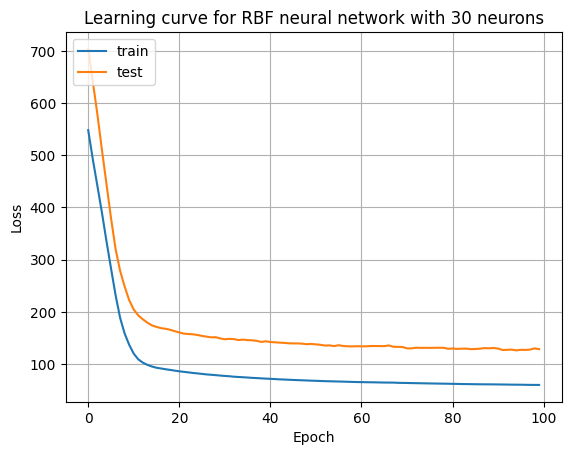

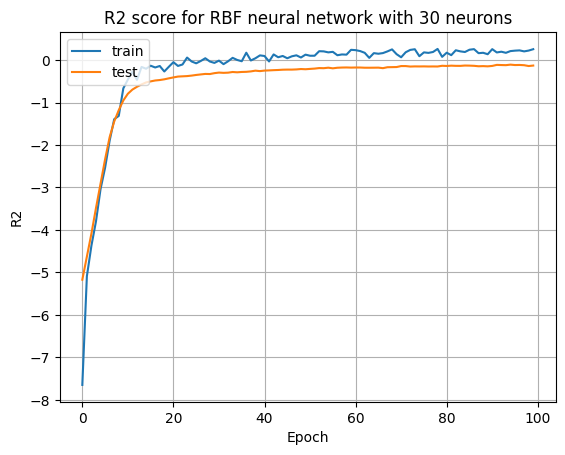

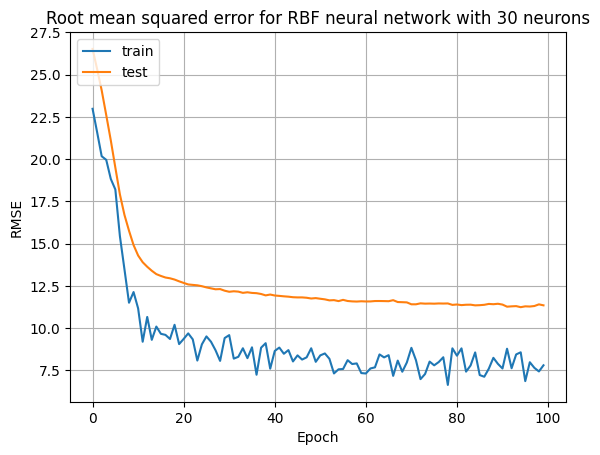

Training with 151 neurons complete in 3.21 seconds.


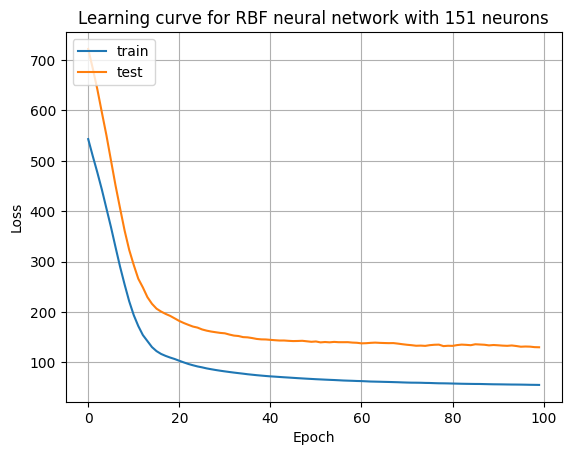

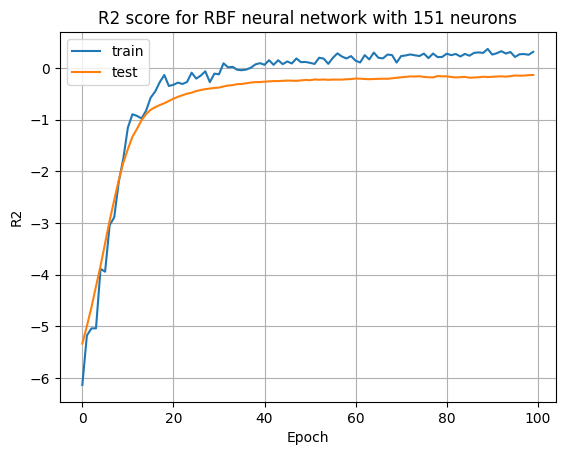

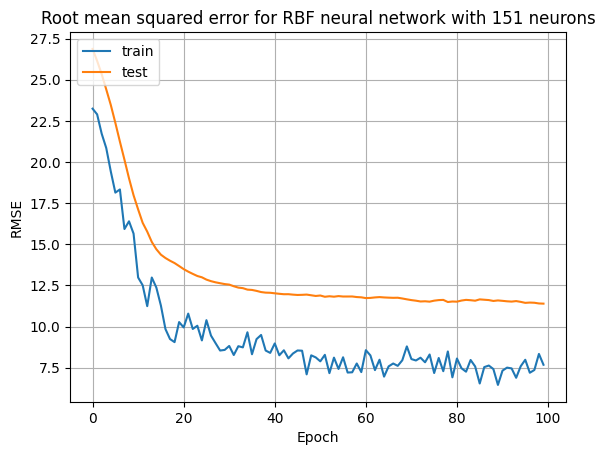

Training with 272 neurons complete in 3.20 seconds.


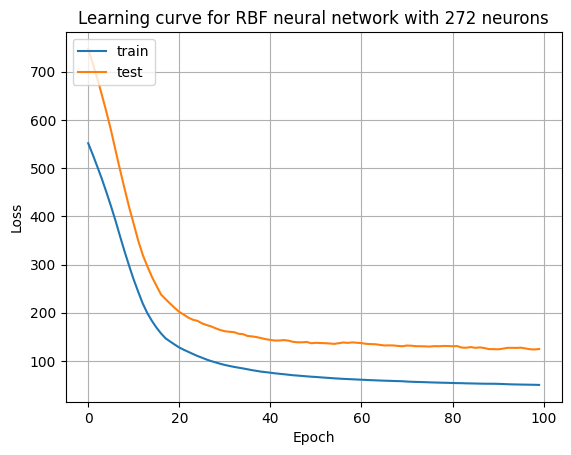

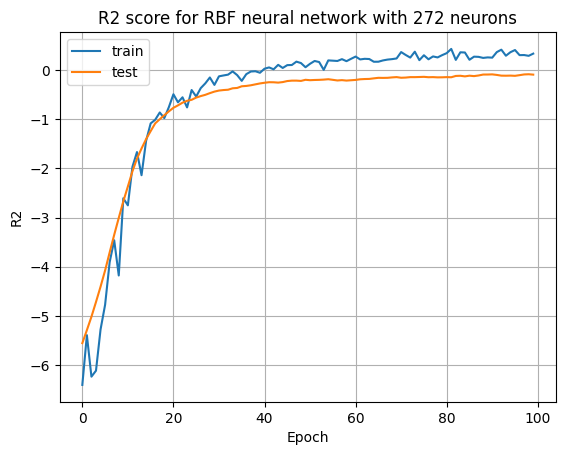

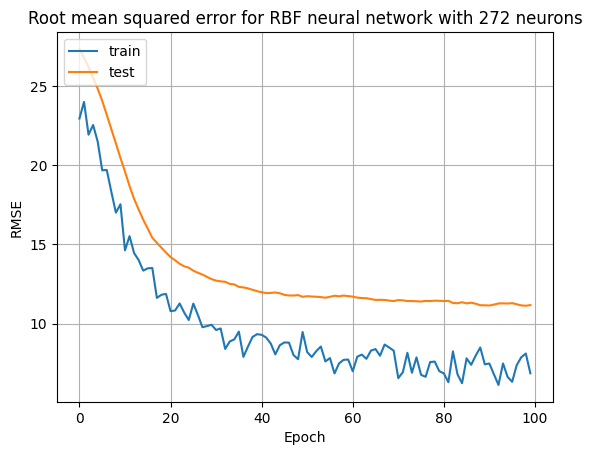

In [53]:
#Train 3 different neural networks with different numbers of neurons in the hidden layer
number_of_neurons = [int(0.1*y_train.shape[0]), int(0.5*y_train.shape[0]), int(0.9*y_train.shape[0])]

for n in number_of_neurons:
    model = Sequential()
    model.add(RBF(n,initializer=InitCentersKMeans(x_train), input_shape=(13, )))
    model.add(Dense(128))
    model.add(Dense(1))
    
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001), 
                  loss=MSE, 
                  metrics=[R2, RMSE])
    
    start = timer()
    history = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_val, y_val),verbose=0)

    end = timer()
    completion_time = "{:.2f}".format(end-start)
    
    print('Training with ' + str(n) + ' neurons complete in ' + str(completion_time) + ' seconds.')

    
    #Plot results

    #loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Learning curve for RBF neural network with ' + str(n) + ' neurons')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    #plt.savefig('Loss with batch size =' + str(batch[i]) + '.pdf')
    plt.grid()
    plt.show()
    
    #R2
    plt.plot(history.history['R2'])
    plt.plot(history.history['val_R2'])
    plt.title('R2 score for RBF neural network with ' + str(n) + ' neurons')
    plt.ylabel('R2')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()
    
    #RMSE
    plt.plot(history.history['RMSE'])
    plt.plot(history.history['val_RMSE'])
    plt.title('Root mean squared error for RBF neural network with ' + str(n) + ' neurons')
    plt.ylabel('RMSE')
    plt.xlabel('Epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.grid()
    plt.show()

Σχολιασμός αποτελεσμάτων:
- **Ως προς τον χρόνο εκτέλεσης** τα τρία δίκτυα έχουν σχετικά όμοιο χρόνο εκτέλεσης, περίπου 3-4 s.
- **Ως προς τις καμπύλες εκμάθησης** τα τρία δίκτυα έχουν σχετικά όμοια πορεία εκμάθησης τοσο των training όσο και των validation δεδομένων
- **Ως προς την μετρική R2** το δίκτυο με 10% του πλήθους δεδομένων εκπαίδευσης (30 νευρώνες) έχει καλύτερη επίδοση
- **Ως προς τηνμετρική RMSE** τα δίκτυα με 10% και 50% του πλήθους δεδομένων εκπαίδευσης (30 και 151 νευρώνες) έχει την καλύτερη απόδοση

# 2. Fine tuning RBF δικτύου

- Για το fine tuning του RBF, θα πρέπει αρχικά να δημιουργήσουμε ένα μοντέλο με όλες τις παραμέτρους και τις τιμές που θέλουμε να λαμβάνουν, σύμφωνα με τις διαδικασίες του keras

In [59]:
def build_model(hp):
    p_h1 = hp.Choice('n_h1', [0.05, 0.15, 0.3, 0.5])
    n_h1 = int(p_h1*y_train.shape[0])
    p_h2 = hp.Choice('n_h2', [32, 64, 128, 256])
    n_h2 = int(p_h2*y_train.shape[0])
    p = hp.Choice('p', [0.2, 0.35, 0.5])
    
    model = Sequential()
    model.add(RBF(n_h1,initializer=InitCentersKMeans(x_train), input_shape=(13, )))
    model.add(Dense(n_h2))
    model.add(Dropout(p))
    model.add(Dense(1))
    
    model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001), 
                  loss=MSE, 
                  metrics=[RMSE])
    return model


- Στη συνέχεια χρησιμοποιώντας τον keras tuner πραγματοποιούμε το tuning του μοντέλου που ορίσαμε προηγουμένως

In [60]:
tuner = keras_tuner.RandomSearch(build_model, objective=keras_tuner.Objective("RMSE", direction='min'))

tuner.search(x_train, y_train,
             epochs=100,
             validation_split=0.2)

Trial 10 Complete [00h 00m 23s]
RMSE: 6.91921854019165

Best RMSE So Far: 6.146178722381592
Total elapsed time: 00h 04m 04s
INFO:tensorflow:Oracle triggered exit


- Αφού ολοκληρωθεί το tuning, παίρνουμε τις βέλτιστες υπερπαραμέτρους του μοντέλου

In [66]:
optimal_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]

n_h1 = int(optimal_hyperparameters.get('n_h1')*y_train.shape[0])
n_h2 = optimal_hyperparameters.get('n_h2')
p = optimal_hyperparameters.get('p')

print(f'Best number of neurons in the RBF layer: ' +str(n_h1))
print(f'Best number of neurons in the second hidden layer: ' +str(n_h2))
print(f'Best value for the dropout probability: ' +str(p))

Best number of neurons in the RBF layer: 151
Best number of neurons in the second hidden layer: 128
Best value for the dropout probability: 0.2


- Τέλος, εκπαιδεύουμε το μοντέλο με τις βέλτιστες παραμέτρους που βρήκαμε

Training with 272 neurons complete in 2.60 seconds.


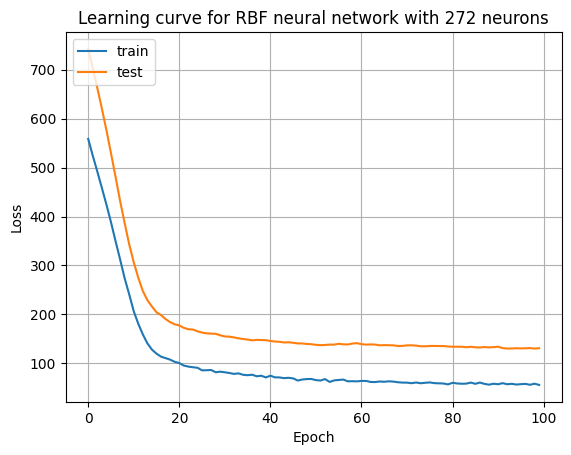

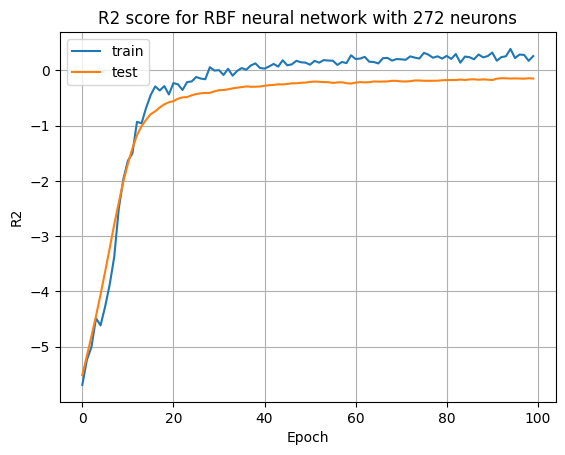

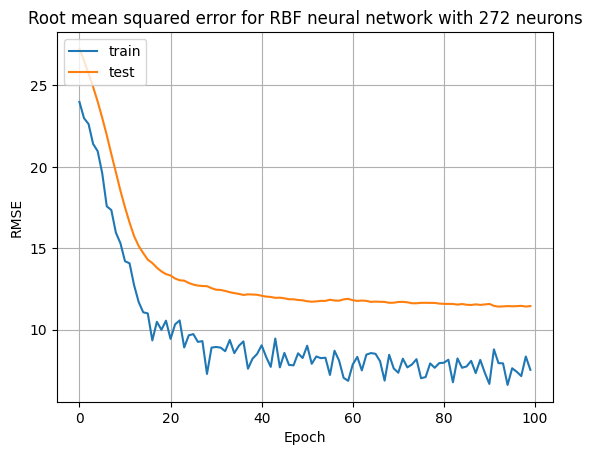

In [67]:
model = Sequential()
model.add(RBF(n_h1,initializer=InitCentersKMeans(x_train), input_shape=(13, )))
model.add(Dense(n_h2))
model.add(Dropout(p))
model.add(Dense(1))

model.compile(optimizer = tf.keras.optimizers.SGD(learning_rate=0.001), 
              loss=MSE, 
              metrics=[R2, RMSE])

start = timer()
history = model.fit(x_train, y_train, batch_size=256, epochs=100, validation_data=(x_val, y_val), verbose=0)

end = timer()
completion_time = "{:.2f}".format(end-start)

print('Training with ' + str(n) + ' neurons complete in ' + str(completion_time) + ' seconds.')


#Plot results

#loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Learning curve for RBF neural network with ' + str(n) + ' neurons')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
#plt.savefig('Loss with batch size =' + str(batch[i]) + '.pdf')
plt.grid()
plt.show()

#R2
plt.plot(history.history['R2'])
plt.plot(history.history['val_R2'])
plt.title('R2 score for RBF neural network with ' + str(n) + ' neurons')
plt.ylabel('R2')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()

#RMSE
plt.plot(history.history['RMSE'])
plt.plot(history.history['val_RMSE'])
plt.title('Root mean squared error for RBF neural network with ' + str(n) + ' neurons')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid()
plt.show()